In [30]:
import gaiaxpy as gxp
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sdss

from astroML.sum_of_norms import sum_of_norms, norm
from astroquery.sdss import SDSS as aq_sdss

In [2]:
# data-relevant constants
DF = pd.read_csv('../data/gaia_sdss_joined.csv')
FIGURE_PATH = '../figures'

GAIA_ID_COLNAME = 'source_id'
SDSS_ID_COLNAME = 'specObjId'
NUM_NORMS = 800

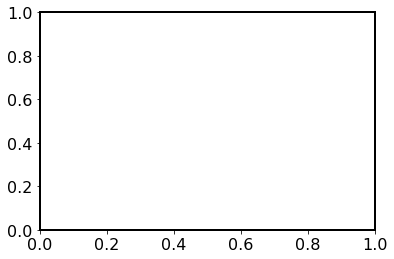

In [23]:
# plot fontsize settings

SMALL_FONT_SIZE = 16
MEDIUM_FONT_SIZE = 20
LARGE_FONT_SIZE = 20

plt.rc('font', size=SMALL_FONT_SIZE)          # default text sizes
plt.rc('axes', titlesize=LARGE_FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_FONT_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_FONT_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_FONT_SIZE)   # fontsize of the figure title

# for axis in [ 'top', 'bottom', 'left', 'right' ]:
#     plt.gca().spines[axis].set_linewidth(2)

In [39]:
# line properties

PROPS = {
    'sdss_raw': { 'color': '#AAAAAA', 'ls': '--', 'lw': 1, 'label': 'SDSS flux' },
    'gaussian': { 'color': '#FF4444', 'ls': '-', 'lw': 2, 'label': 'Gaussian fit to SDSS flux' },
    'gaia': {'color': '#4444FF', 'ls': '-', 'lw': 2, 'label': 'Gaia flux' }
}

In [162]:
def plot_w_props(x, y, props):
    plt.plot(x, y, color=props['color'], ls=props['ls'], lw=props['lw'], label=props['label'])
    
def plot(*, gaia_id=None, sdss_id=None):
    if gaia_id is None and sdss_id is None:
        print('No ID supplied')
    elif sdss_id is None:    
        try:
            sdss_id = DF.loc[DF[GAIA_ID_COLNAME] == gaia_id][SDSS_ID_COLNAME].to_list()[0]
        except:
            print('Could not find an SDSS ID corresponding to the provided Gaia ID')
    elif gaia_id is None:
        try:
            gaia_id = DF.loc[DF[SDSS_ID_COLNAME] == sdss_id][GAIA_ID_COLNAME].to_list()[0]
        except:
            print('Could not find an Gaia ID corresponding to the provided SDSS ID')
    
    gaia_flux, gaia_sampling = gxp.calibrate([gaia_id], truncation=True)
    
    gaia_flux = gaia_flux['flux'][0]
    gaia_sampling = gaia_sampling
    
    sp = sdss.SpecObj(int(sdss_id))
    data = aq_sdss.get_spectra(plate=sp.plate, mjd=sp.mjd, fiberID=sp.fiberID)
    
    spec_data = data[0][1].data

    sdss_sampling = 10 ** spec_data['loglam'] / 10  # Convert log wavelength to linear and Å to nm
    sdss_flux = spec_data['flux'] * 1e-19 # Convert SDSS units (1e-17 in cgs) to Gaia units (SI)

    w_best, rms, locs, widths = sum_of_norms(sdss_sampling, sdss_flux, NUM_NORMS,
                                             spacing='linear',
                                             full_output=True)

    norms = w_best * norm(sdss_sampling[:, None], locs, widths)

    # plot the results

    plt.figure(figsize=(20, 10))
    plot_w_props(sdss_sampling, sdss_flux, PROPS['sdss_raw'])
    plot_w_props(sdss_sampling, norms.sum(1), PROPS['gaussian'])
    plot_w_props(gaia_sampling, gaia_flux, PROPS['gaia'])

    plt.legend(loc=0)

    plt.text(0.97, 0.8, f"rms error = {rms:.2}",ha='right', va='top', transform=plt.gca().transAxes)
    plt.title(f"Gaia source_id {gaia_id}\n SDSS specObjId {sdss_id}")
    
    plt.xlabel('$\\lambda$ [nm]')
    plt.ylabel('flux [W m$^{-2}$ nm$^{-1}$]')
    
    plt.xlim(350, 950)
    plt.xticks(np.arange(360, 960, 20))
    
    for axis in [ 'top', 'bottom', 'left', 'right' ]:
        plt.gca().spines[axis].set_linewidth(2)
    
    if not os.path.exists(FIGURE_PATH):
        os.mkdir(FIGURE_PATH)

    plt.savefig(f'{FIGURE_PATH}/gaia_{gaia_id}_sdss_{sdss_id}.png')
    plt.show()

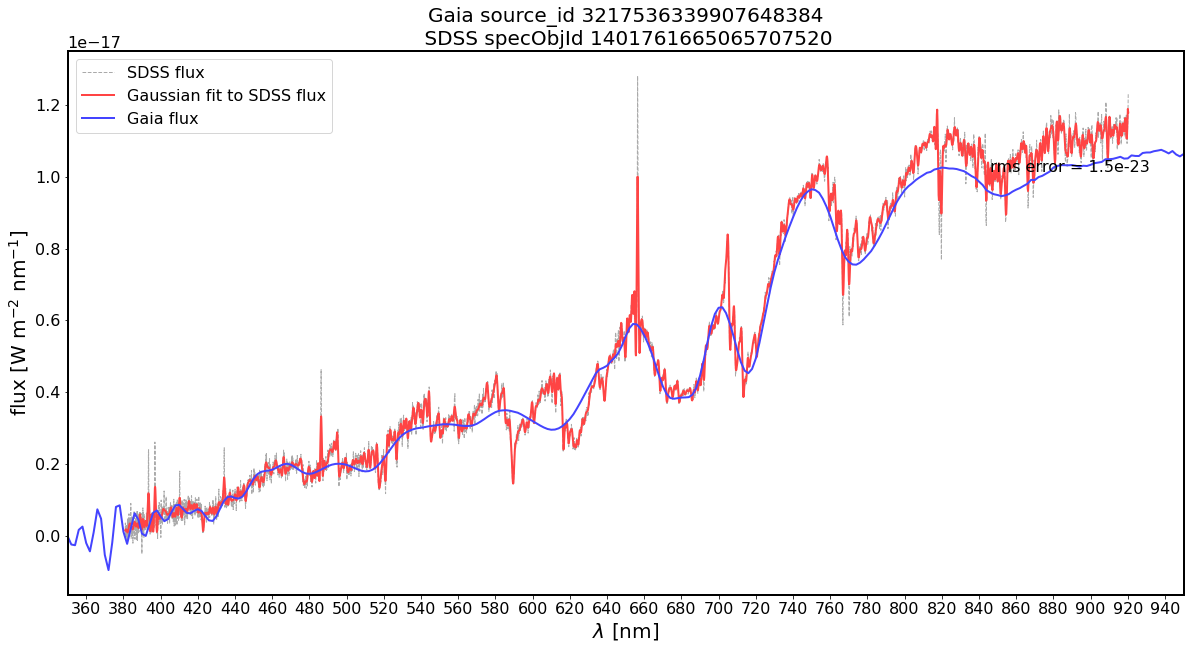

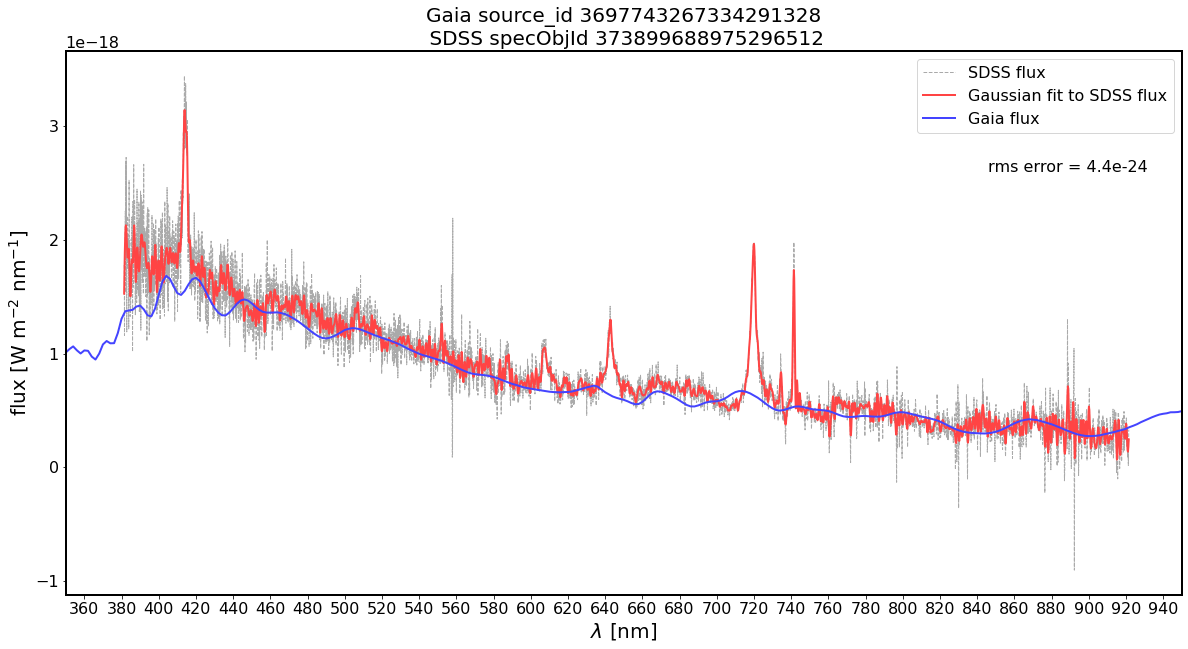

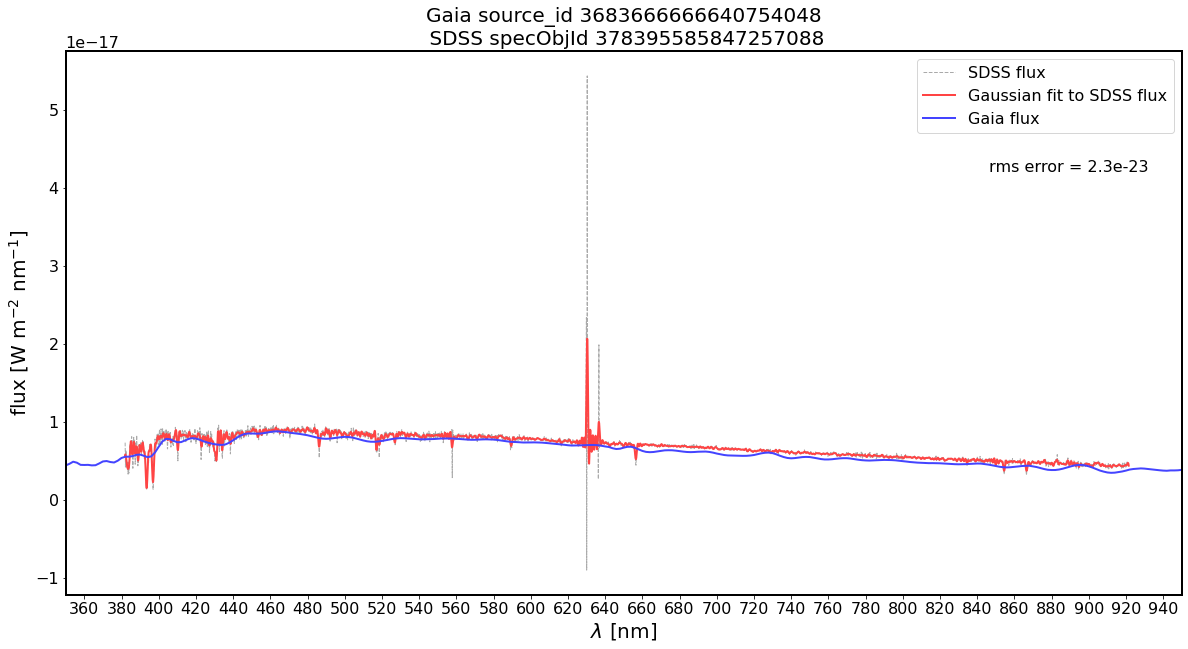

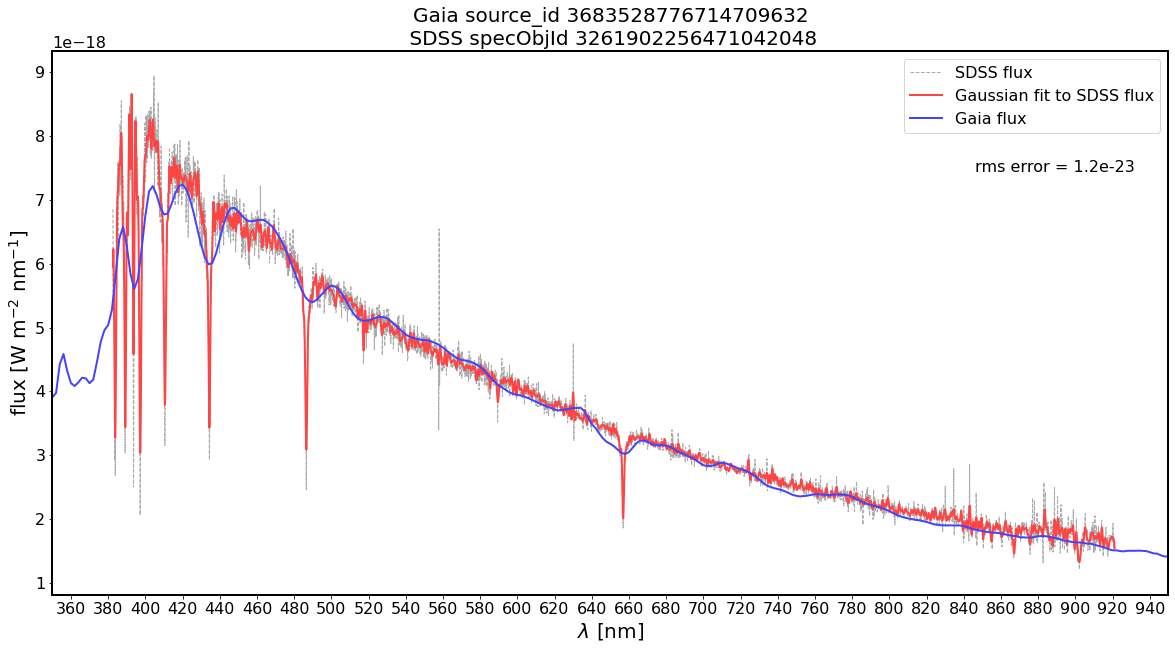

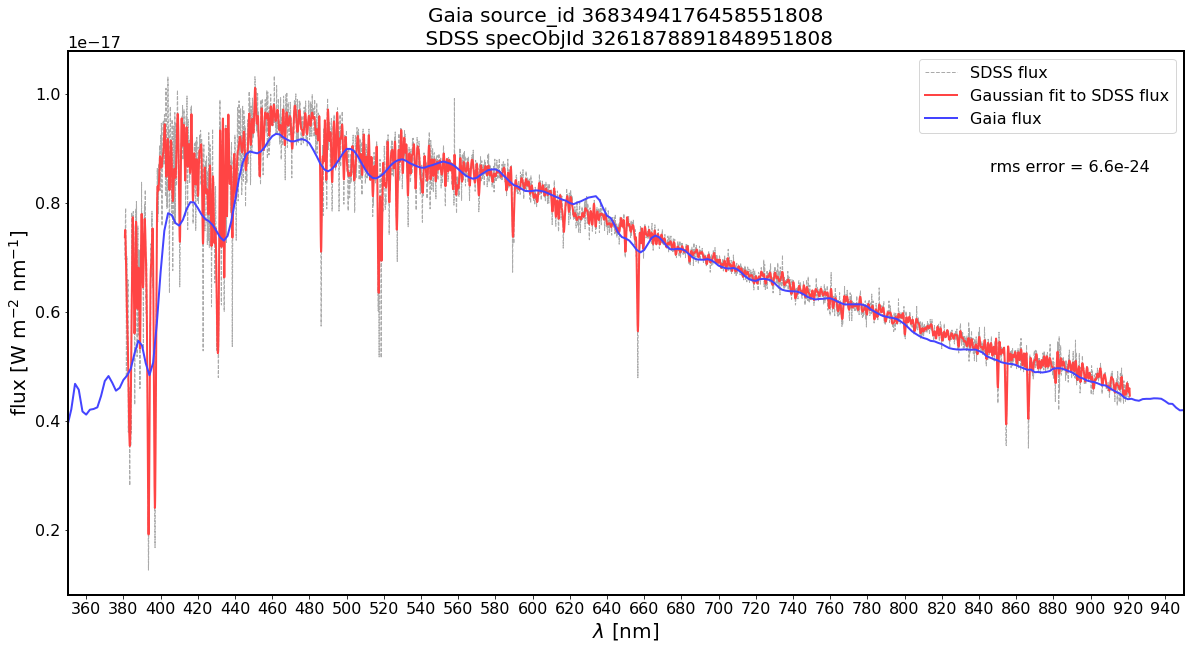

/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


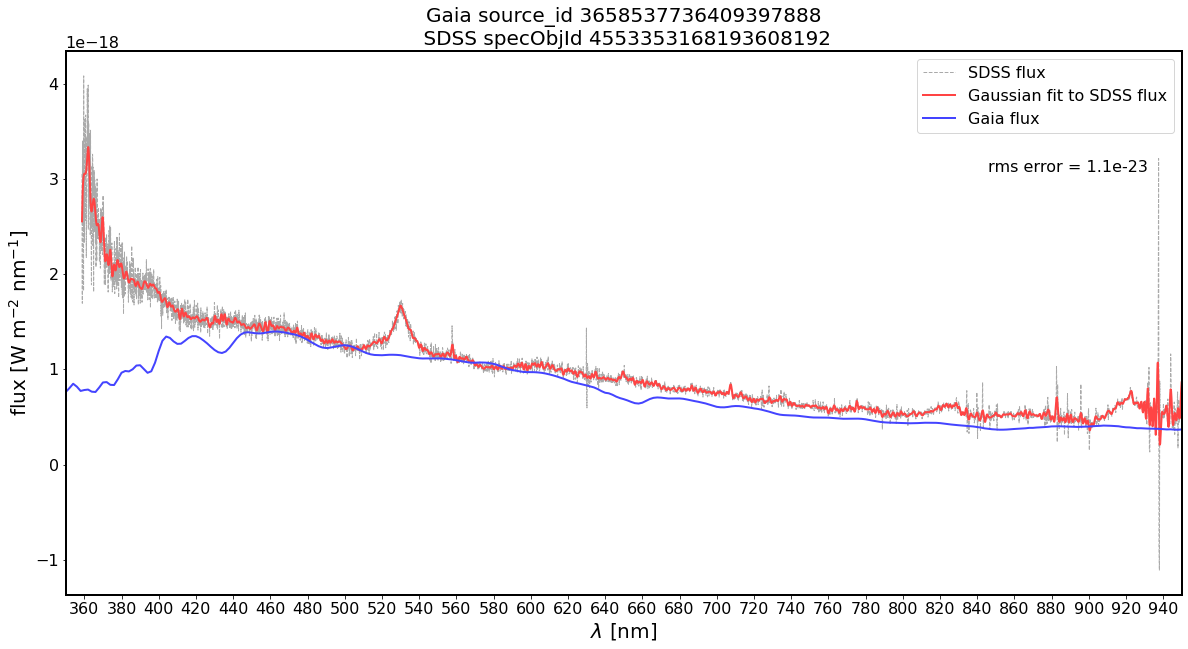

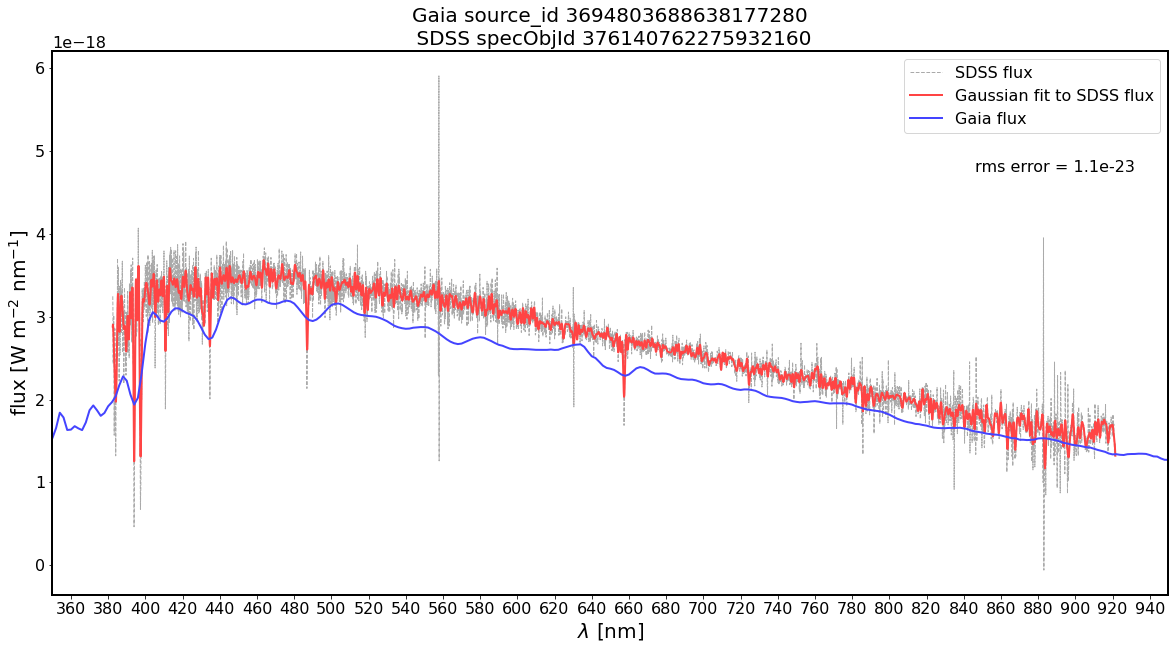

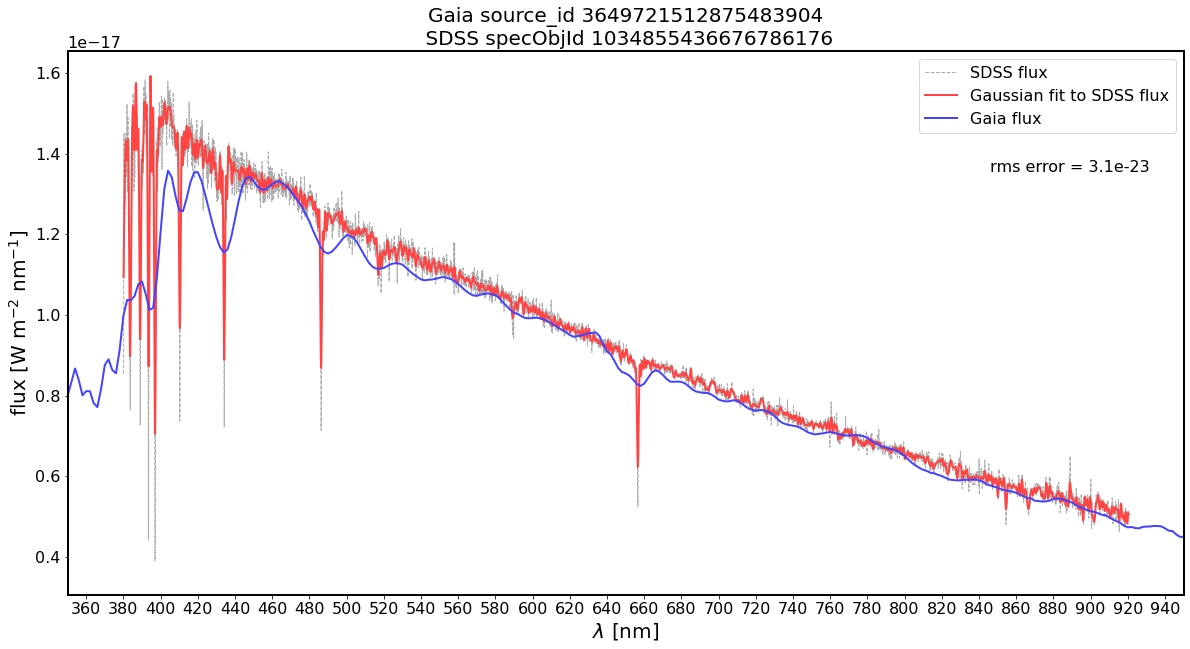

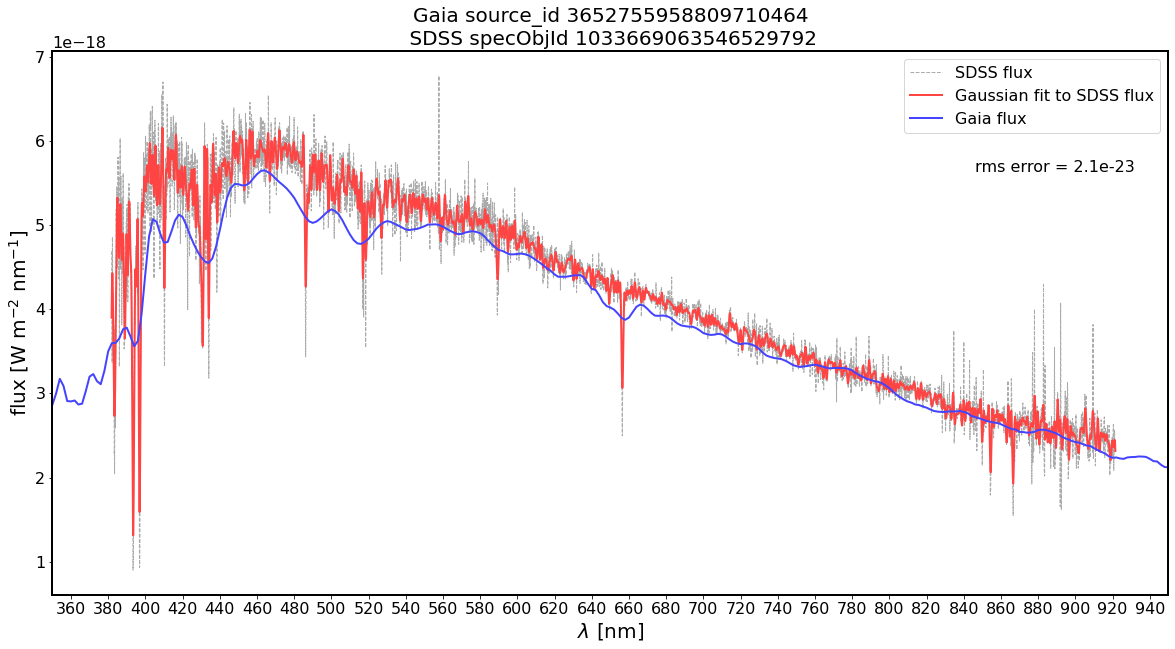

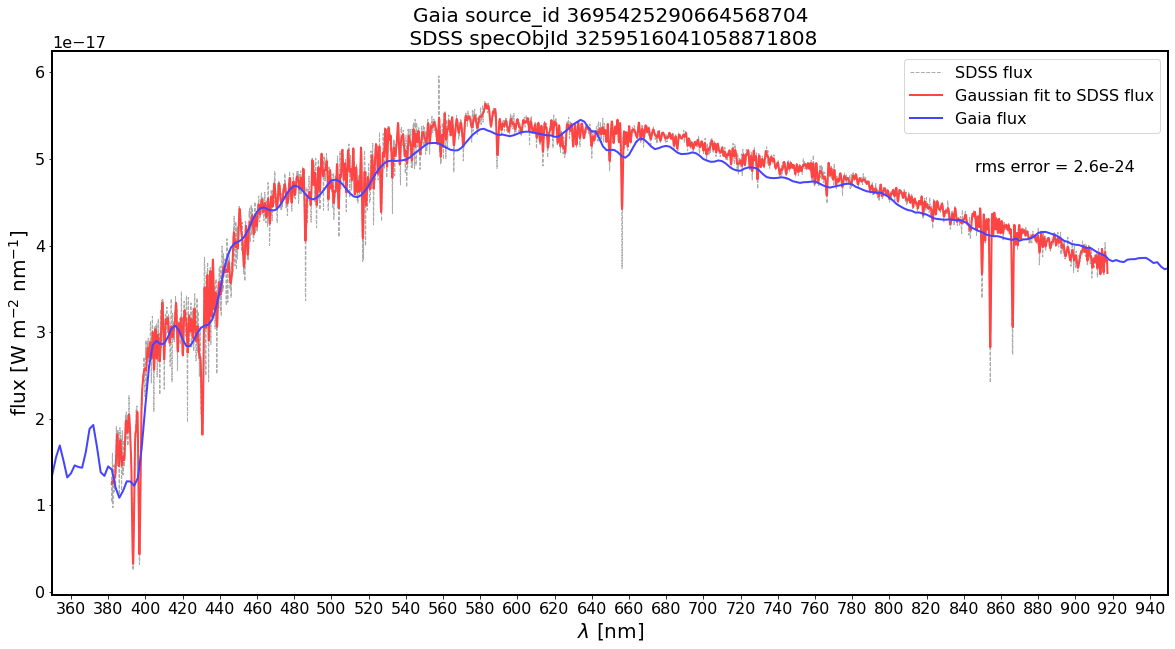

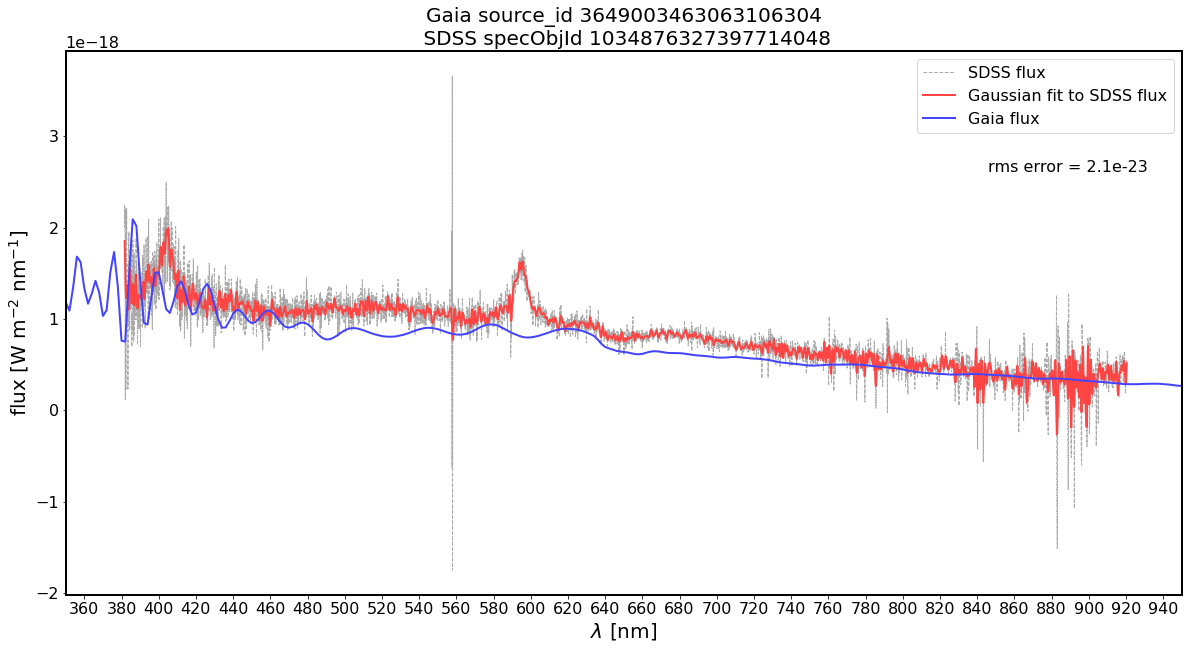

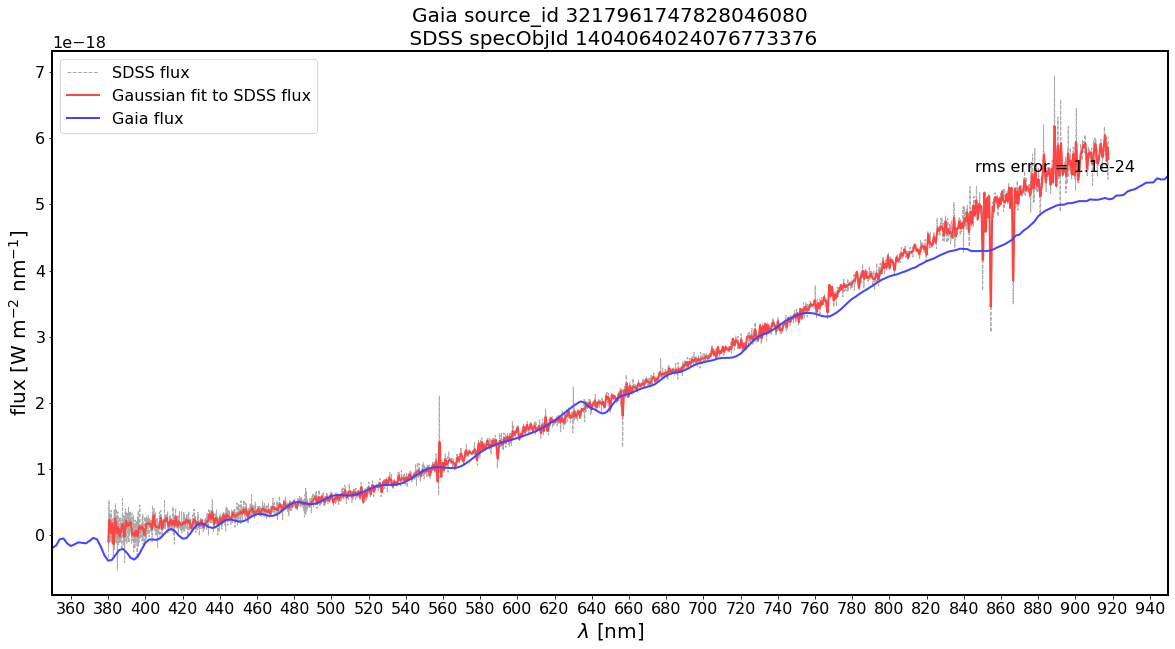

/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


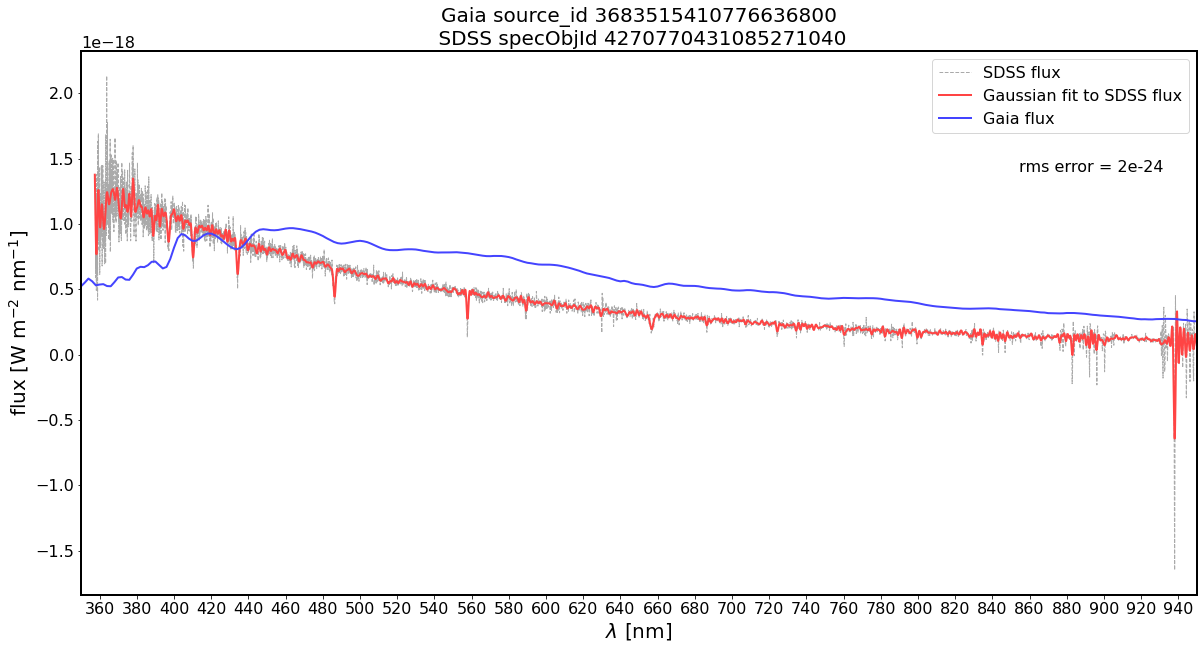

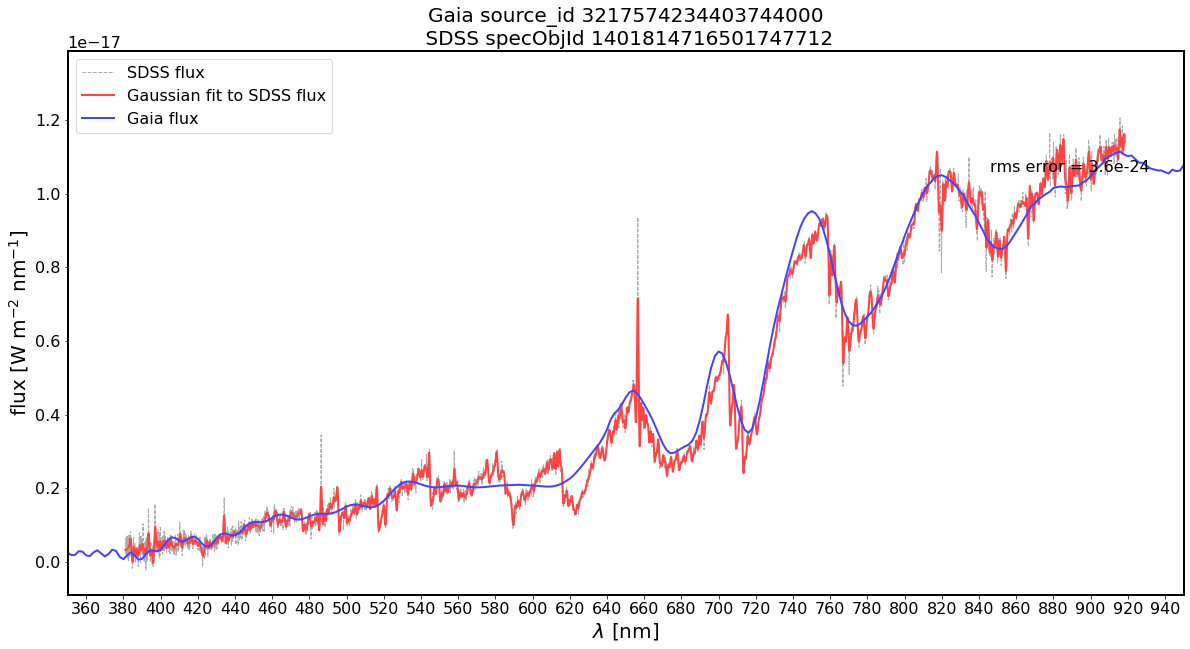

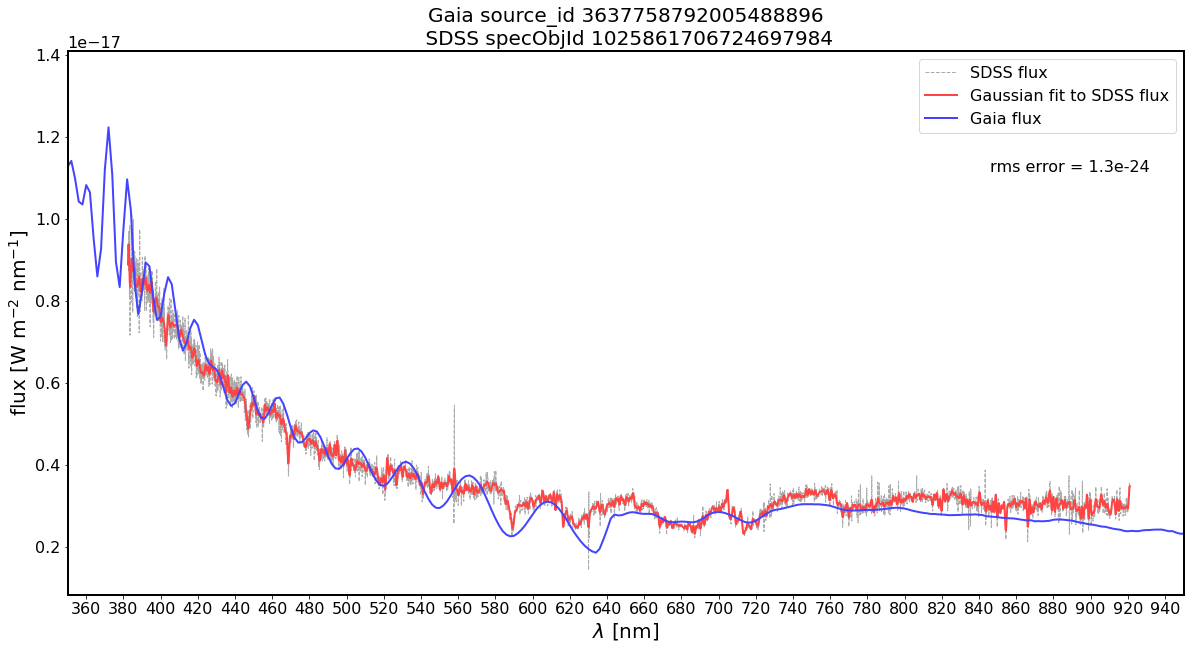

/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


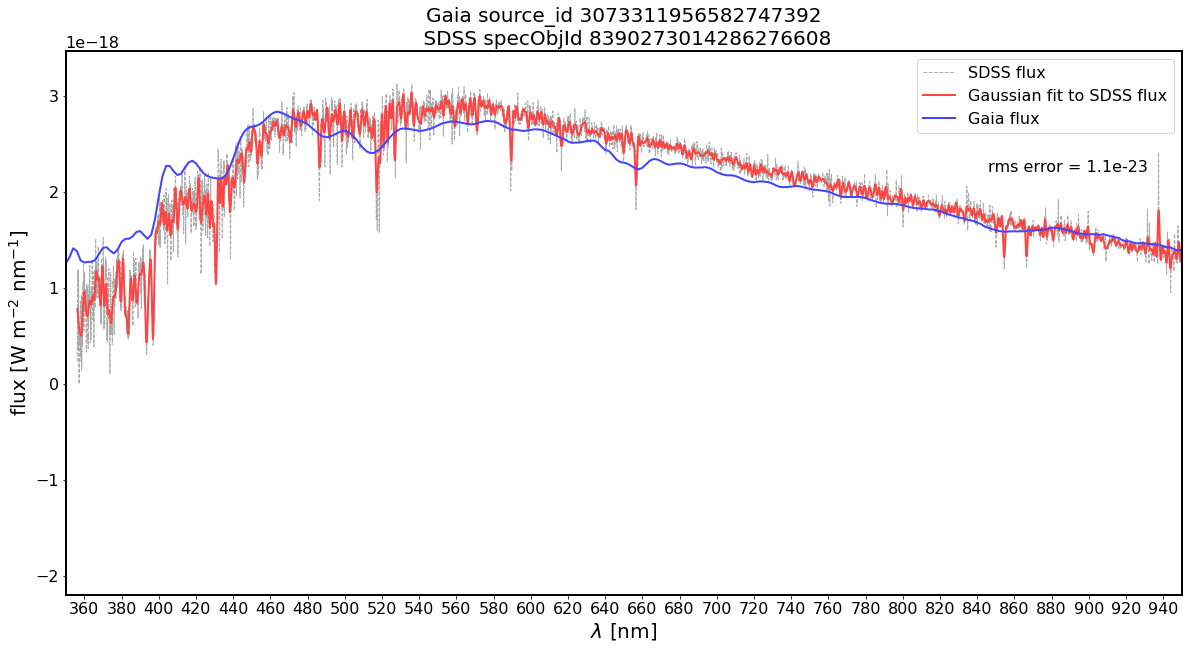

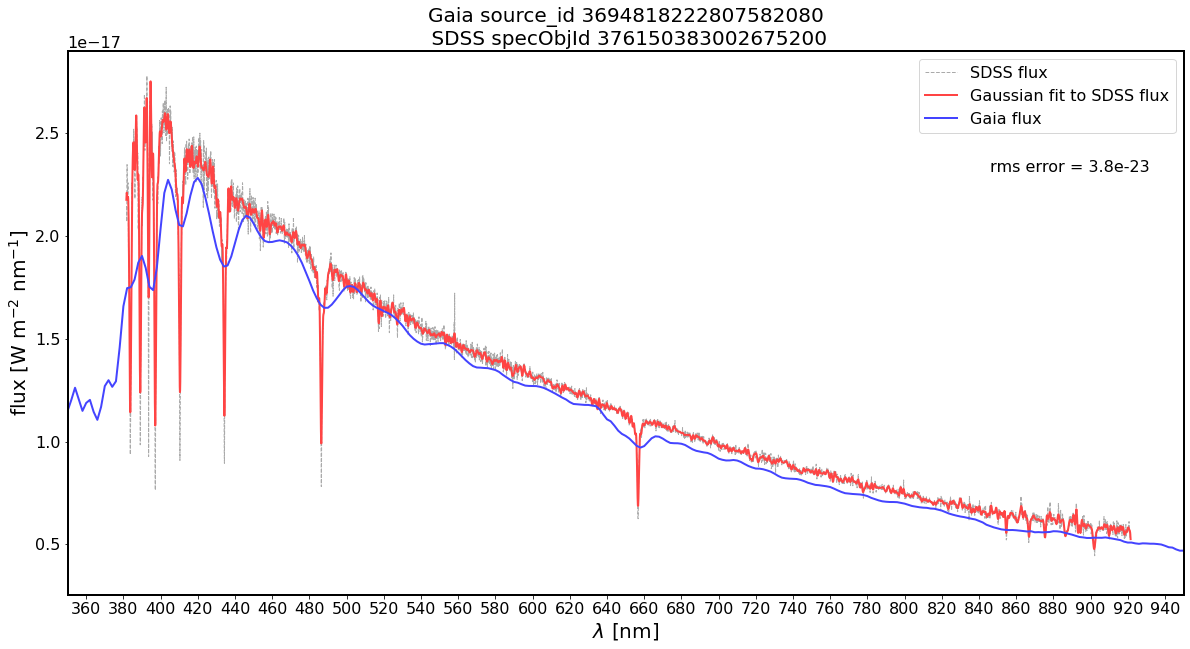

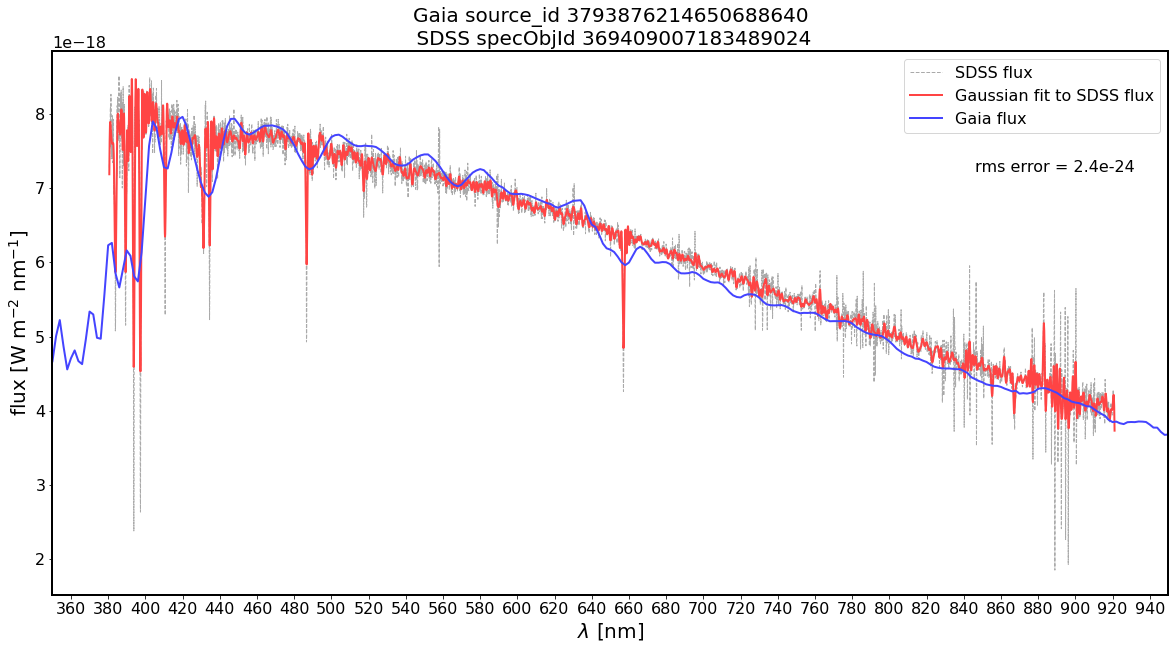

/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


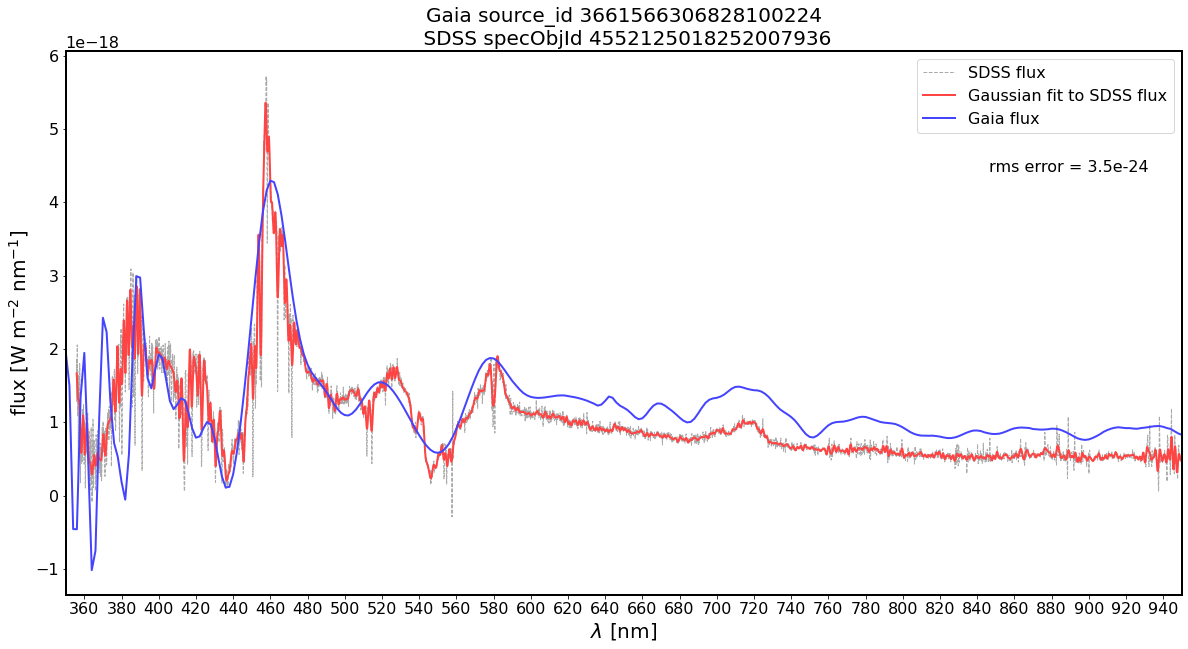

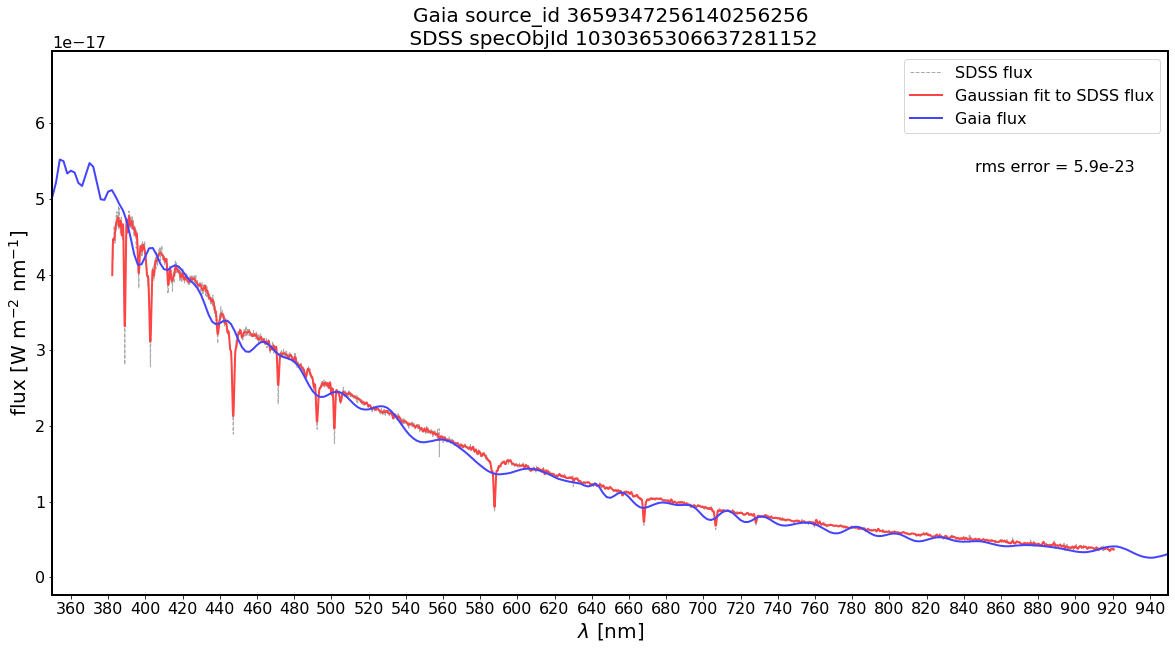

In [163]:
for gaia_id in DF[:20][GAIA_ID_COLNAME]:
    plot(gaia_id=gaia_id)

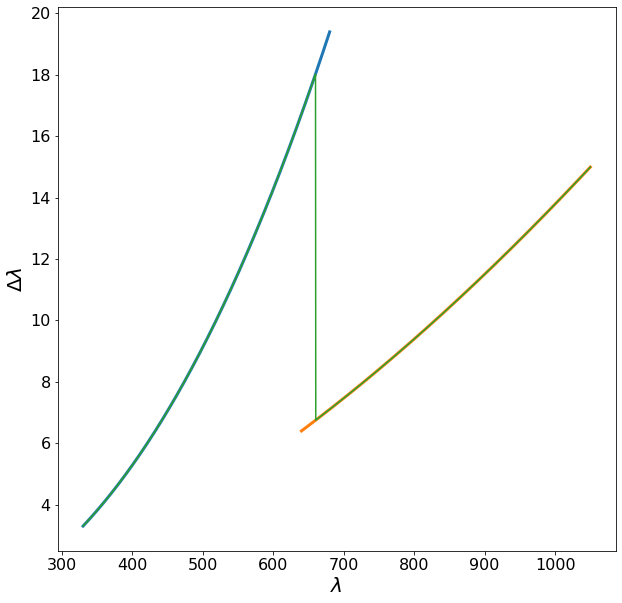

In [213]:
x1 = np.linspace(330, 680, 1000)
y1 = 3.30 * (x1/330)**2.45

x2 = np.linspace(640, 1050, 1000)
y2 = 6.40 * (x2/640)**1.72

plt.figure(figsize=(10, 10))
plt.plot(x1, y1, lw=3)
plt.plot(x2, y2, lw=3)

def deltaXP(wvl):
    y1 = lambda x: 3.30 * (x/330)**2.45
    y2 = lambda x: 6.40 * (x/640)**1.72
#     y_mid = lambda x: (y2(680) * (x - 640) + y1(640) * (680 - x))/40
    
#     return np.piecewise(wvl, \
#                         [wvl < 640, (640 <= wvl) & (wvl <= 680), wvl > 680], \
#                         [y1, y_mid, y2])
    return np.piecewise(wvl, \
                        [wvl < 660, wvl >= 660], \
                        [y1, y2])
    
x = np.linspace(330, 1050, 2000)
plt.xlabel('$\\lambda$')
plt.ylabel('$\\Delta\\lambda$')
plt.plot(x, deltaXP(x))

In [248]:
def plot_conv(*, gaia_id=None, sdss_id=None, k=1):
    if gaia_id is None and sdss_id is None:
        print('No ID supplied')
    elif sdss_id is None:    
        try:
            sdss_id = DF.loc[DF[GAIA_ID_COLNAME] == gaia_id][SDSS_ID_COLNAME].to_list()[0]
        except:
            print('Could not find an SDSS ID corresponding to the provided Gaia ID')
    elif gaia_id is None:
        try:
            gaia_id = DF.loc[DF[SDSS_ID_COLNAME] == sdss_id][GAIA_ID_COLNAME].to_list()[0]
        except:
            print('Could not find an Gaia ID corresponding to the provided SDSS ID')
            
    # get sdss data
    sp = sdss.SpecObj(int(sdss_id))
    data = aq_sdss.get_spectra(plate=sp.plate, mjd=sp.mjd, fiberID=sp.fiberID)
    
    spec_data = data[0][1].data

    sdss_sampling = 10 ** spec_data['loglam'] / 10  # Convert log wavelength to linear and Å to nm
    sdss_flux = spec_data['flux'] * 1e-19 # Convert SDSS units (1e-17 in cgs) to Gaia units (SI)
    
    # get gaia data and calibrate using sdss sampling
    gaia_flux = gxp.calibrate([gaia_id], sampling=sdss_sampling, truncation=True)[0]['flux'][0]

    weights, fit_rms, locs, widths = sum_of_norms(sdss_sampling, sdss_flux, NUM_NORMS,
                                                 spacing='linear',
                                                 full_output=True)
    
    # convolve sdss with sigma_gaia
    sigma_conv = np.sqrt(widths**2 + k**2 * deltaXP(locs)**2)  # convolve gaussian sigmas with sigma_gaia
    norms = weights * norm(sdss_sampling[:, None], locs, sigma_conv)
    sdss_conv = norms.sum(1)
    
    fit_flux = np.trapz(sdss_flux, sdss_sampling)
    conv_flux = np.trapz(sdss_conv, sdss_sampling)
    
    # compute rms error and quotient between sdss convolution and gaia data
    match_rms = np.sqrt(np.mean((sdss_conv - gaia_flux)**2))
    quot = np.mean(sdss_conv/gaia_flux)

    # plot the results

    plt.figure(figsize=(20, 10))
    plot_w_props(sdss_sampling, sdss_flux, PROPS['sdss_raw'])
    plot_w_props(sdss_sampling, sdss_conv, PROPS['gaussian'])
    plot_w_props(sdss_sampling, gaia_flux, PROPS['gaia'])

    plt.legend(loc=0)

    plt.text(0.97, 0.8, f"gaussian fit rms error = {fit_rms:.2}", ha='right', va='top', transform=plt.gca().transAxes)
    plt.text(0.97, 0.75, f"k = {k:.2}", ha='right', va='top', transform=plt.gca().transAxes)
    plt.text(0.97, 0.7, f"sdss - gaia rms error = {match_rms:.3}", ha='right', va='top', transform=plt.gca().transAxes)
    plt.text(0.97, 0.65, f"sdss/gaia quotient = {quot:.3}", ha='right', va='top', transform=plt.gca().transAxes)
    plt.text(0.97, 0.6, f"integrated flux (fit) = {fit_flux:.3}", ha='right', va='top', transform=plt.gca().transAxes)
    plt.text(0.97, 0.55, f"integrated flux (conv) = {conv_flux:.3}", ha='right', va='top', transform=plt.gca().transAxes)
    plt.title(f"Gaia source_id {gaia_id}\n SDSS specObjId {sdss_id}")
    
    plt.xlabel('$\\lambda$ [nm]')
    plt.ylabel('flux [W m$^{-2}$ nm$^{-1}$]')
    
    plt.xlim(350, 950)
    plt.xticks(np.arange(360, 960, 20))
    
    for axis in [ 'top', 'bottom', 'left', 'right' ]:
        plt.gca().spines[axis].set_linewidth(2)
    
    if not os.path.exists(FIGURE_PATH):
        os.mkdir(FIGURE_PATH)

    plt.savefig(f'{FIGURE_PATH}/gaia_{gaia_id}_sdss_{sdss_id}_k_{int(k*10)}.png')
    plt.show()
    
    return match_rms

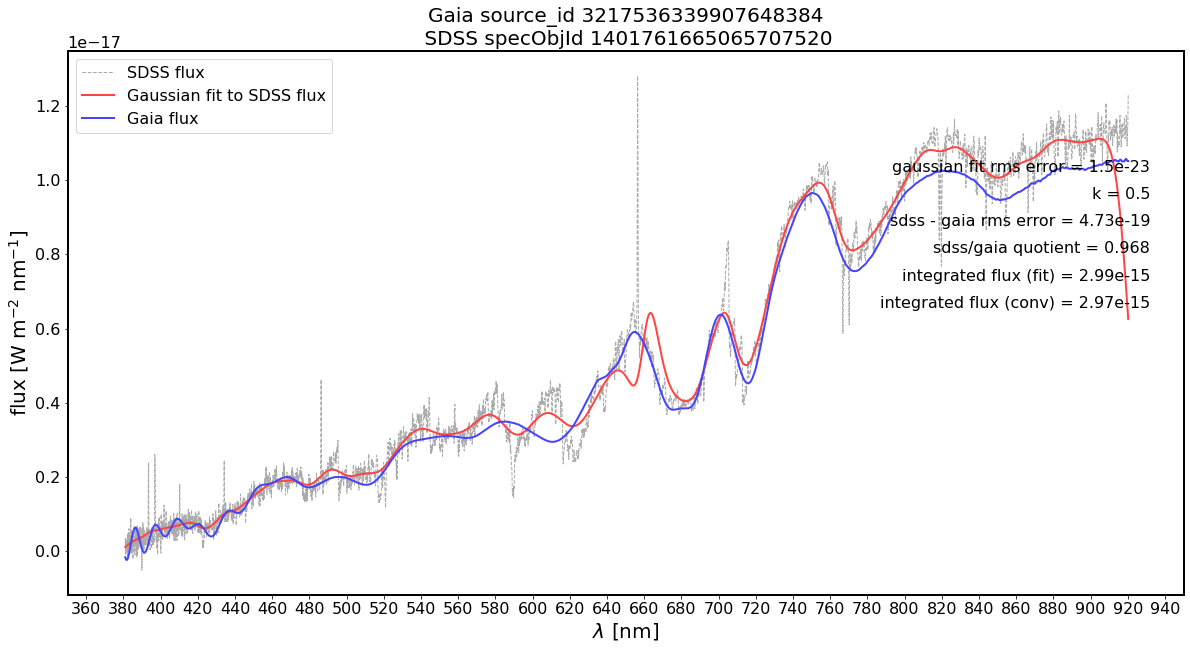

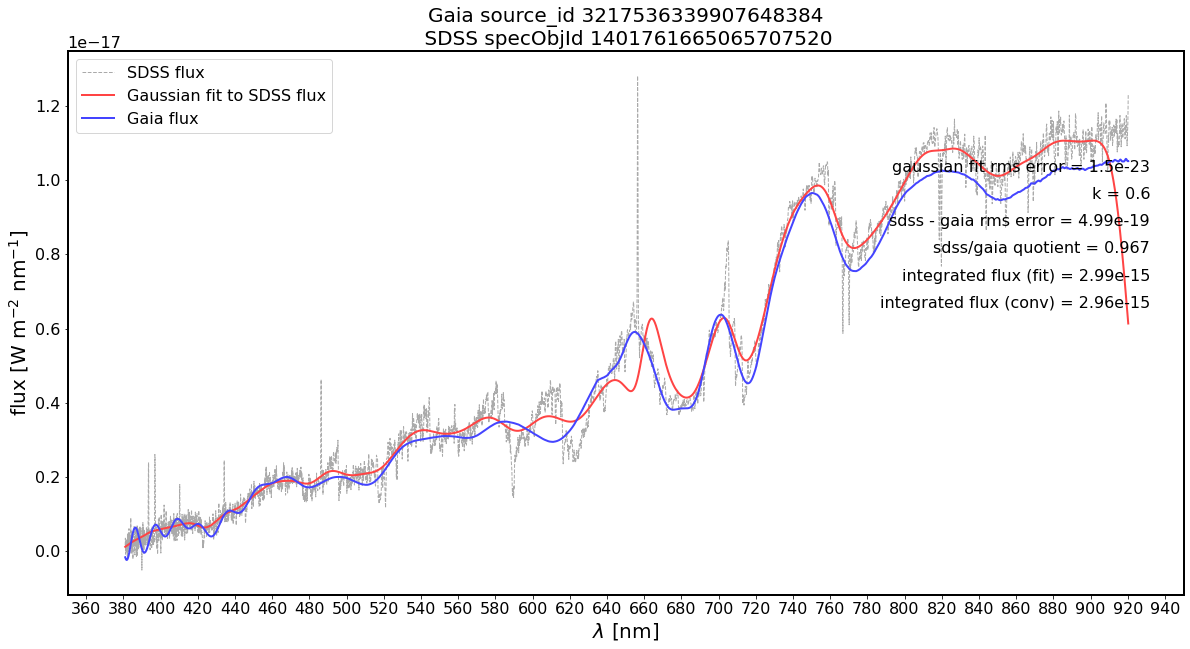

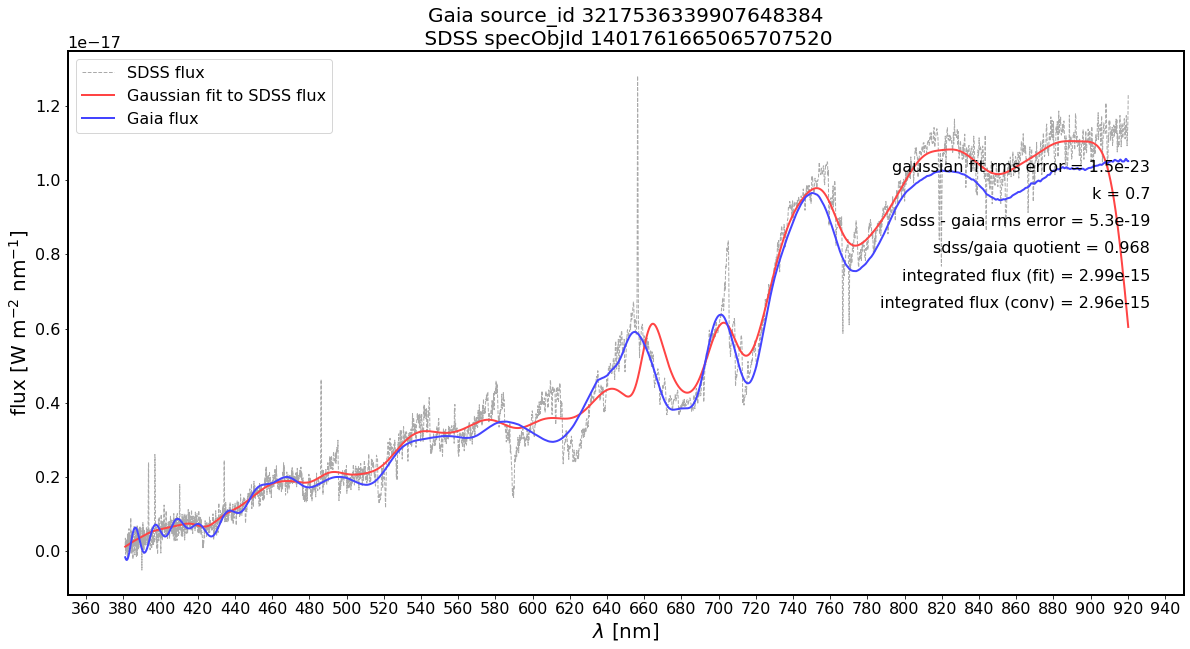

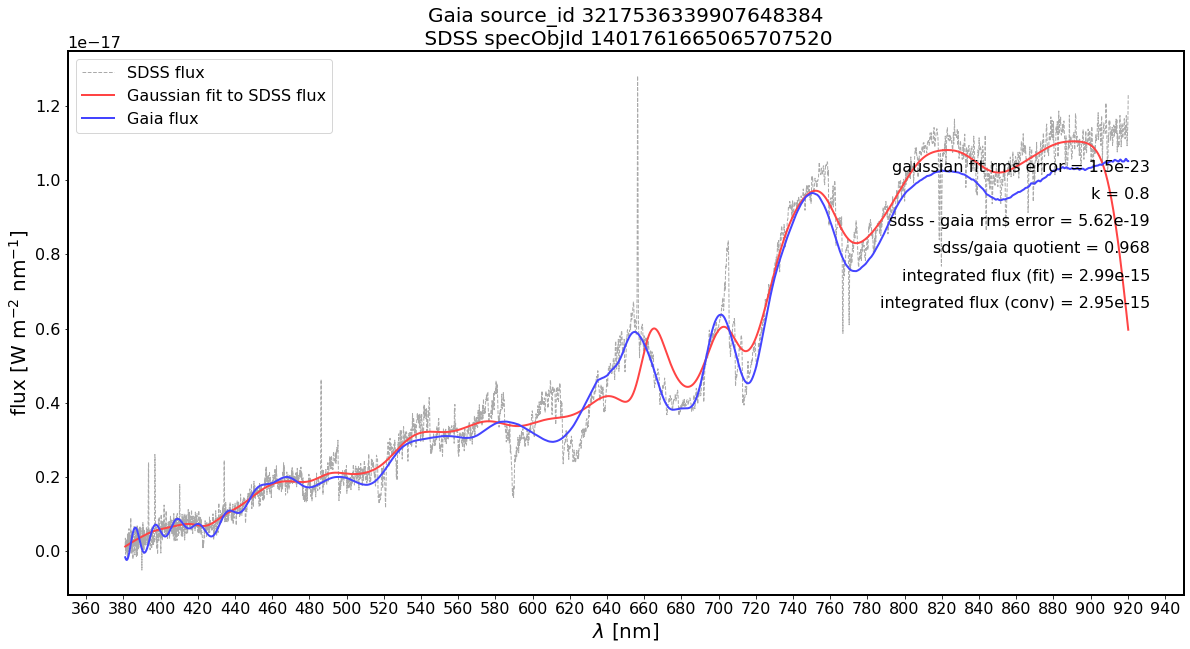

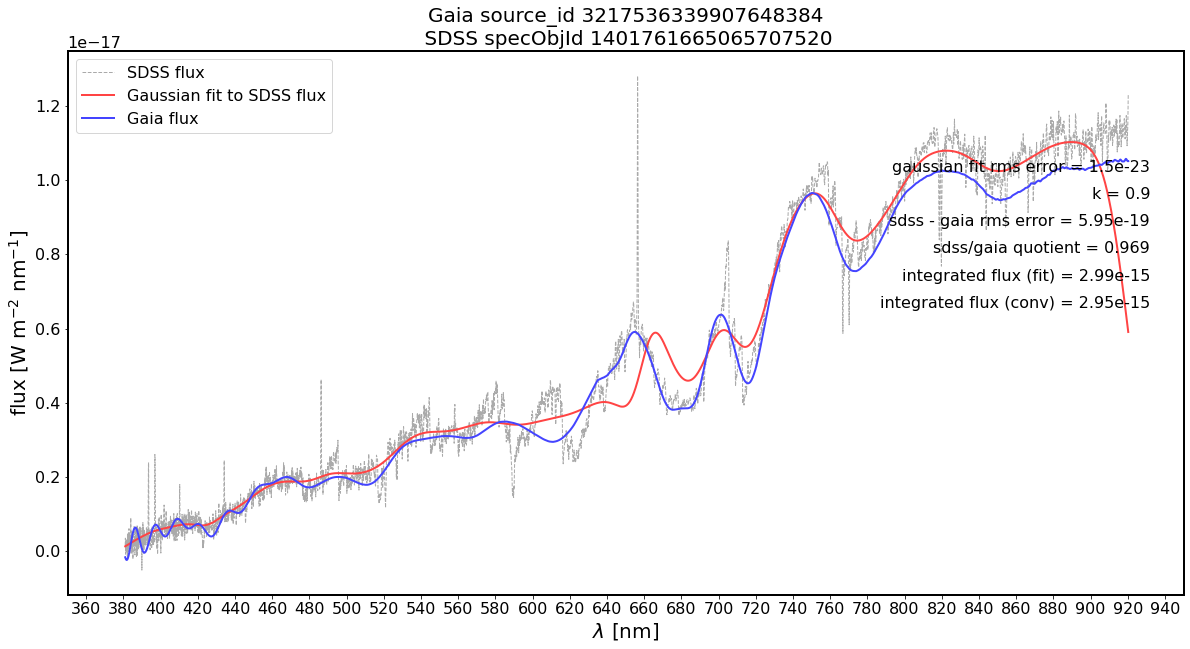

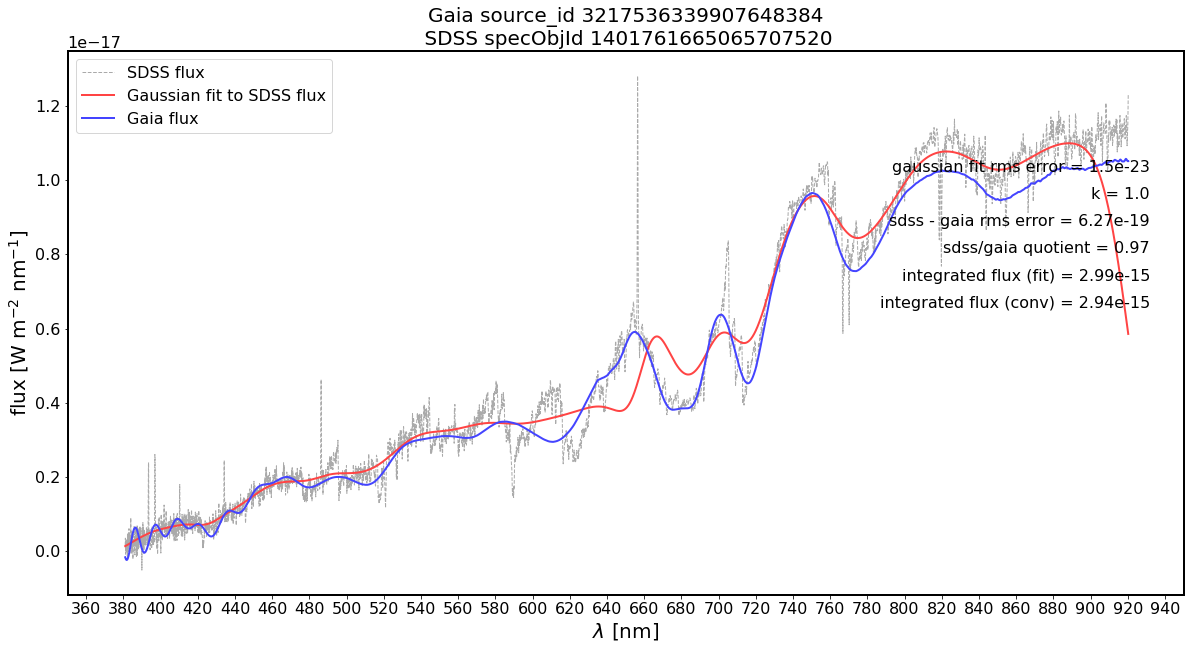

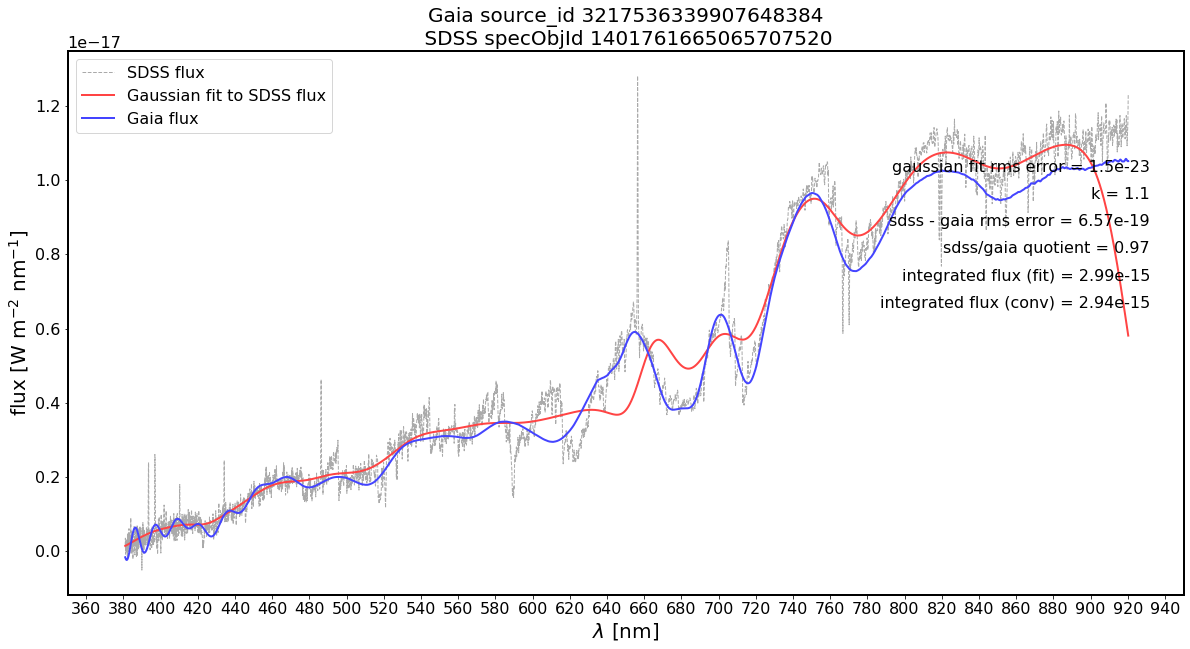

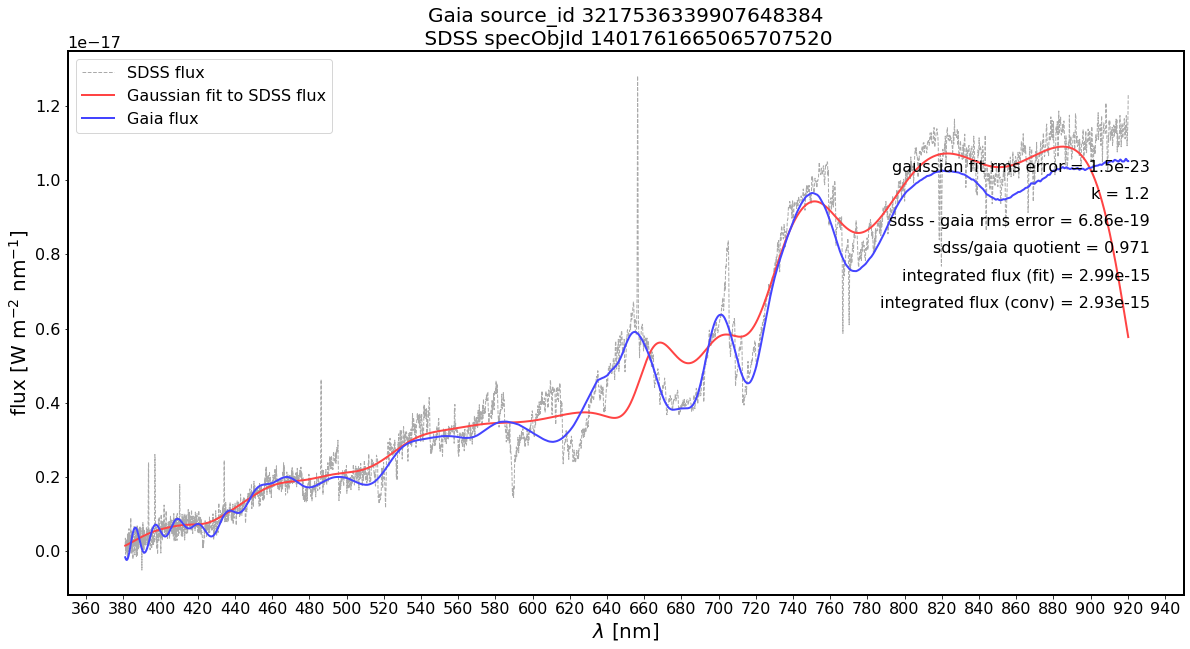

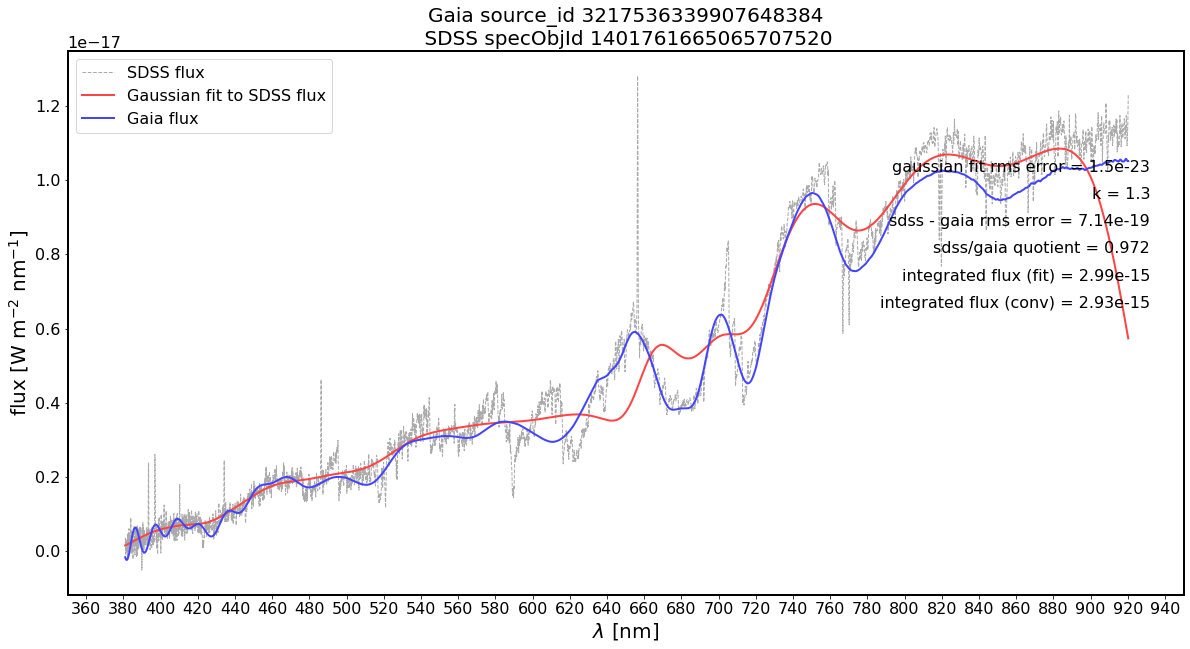

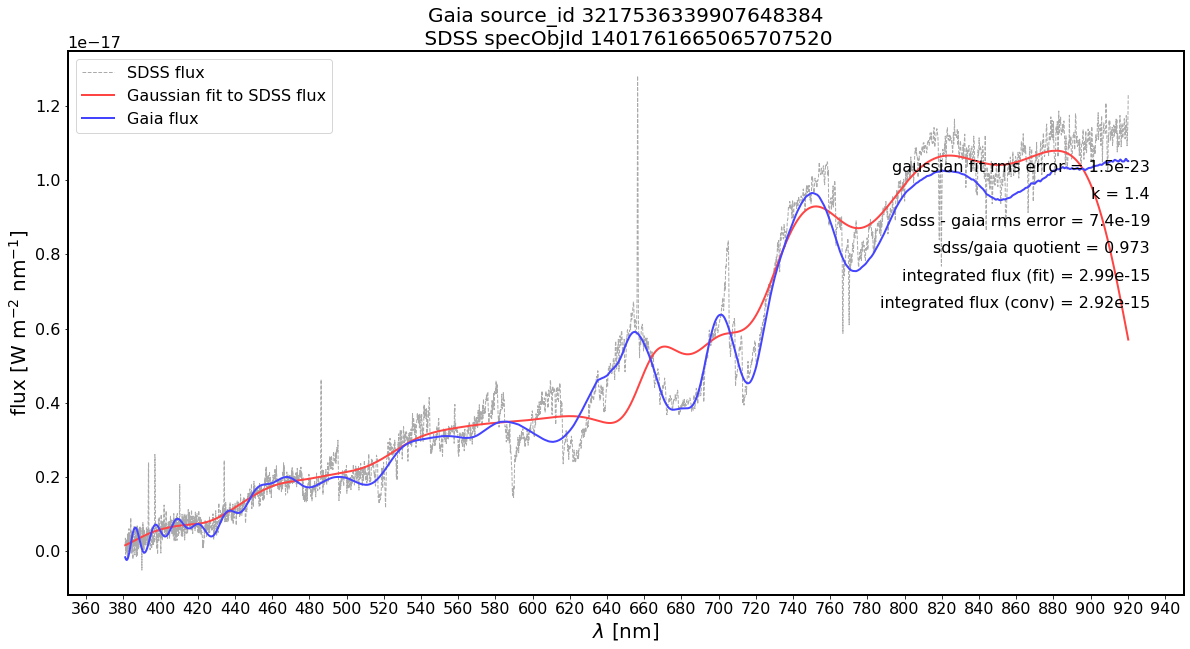

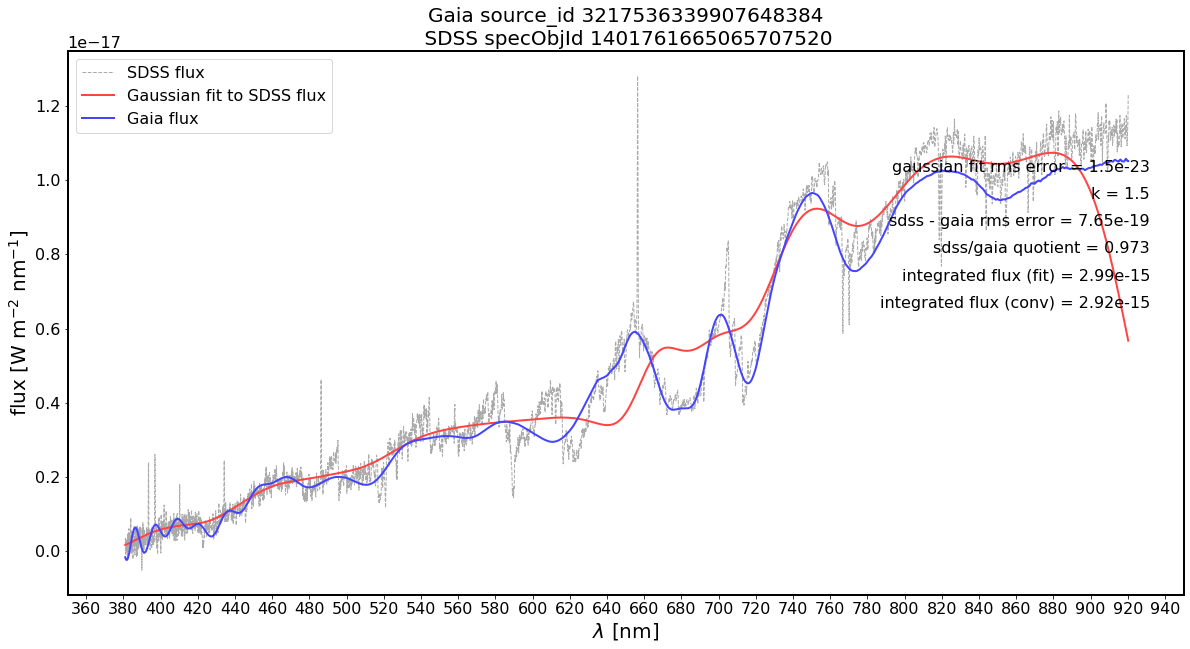

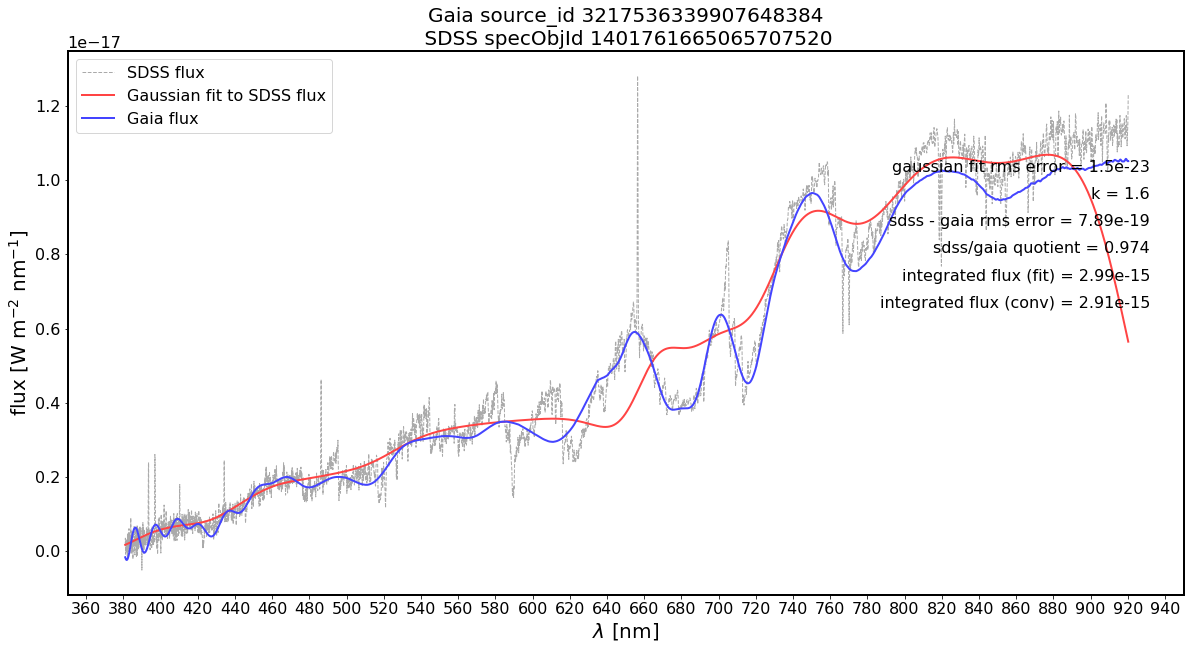

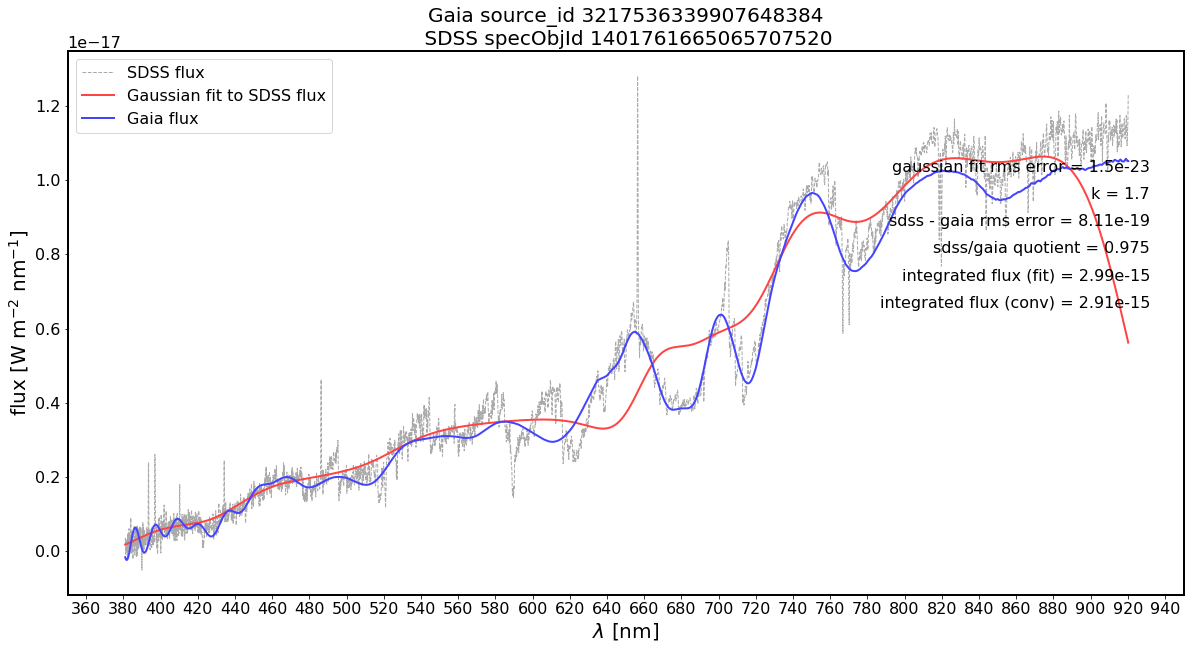

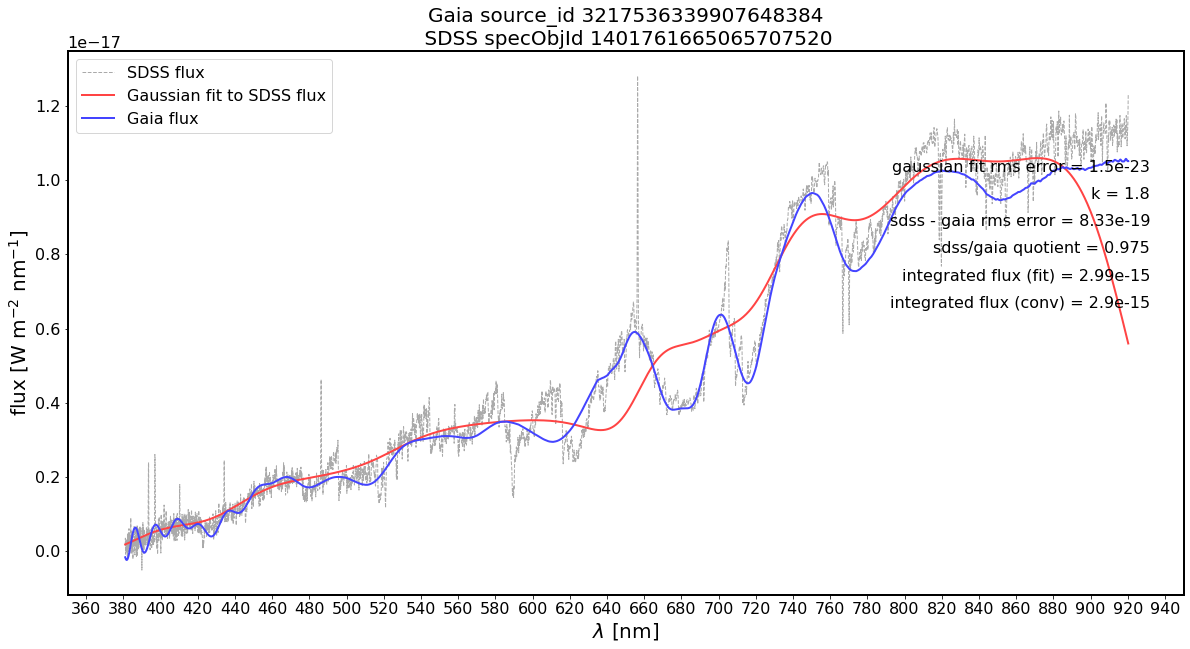

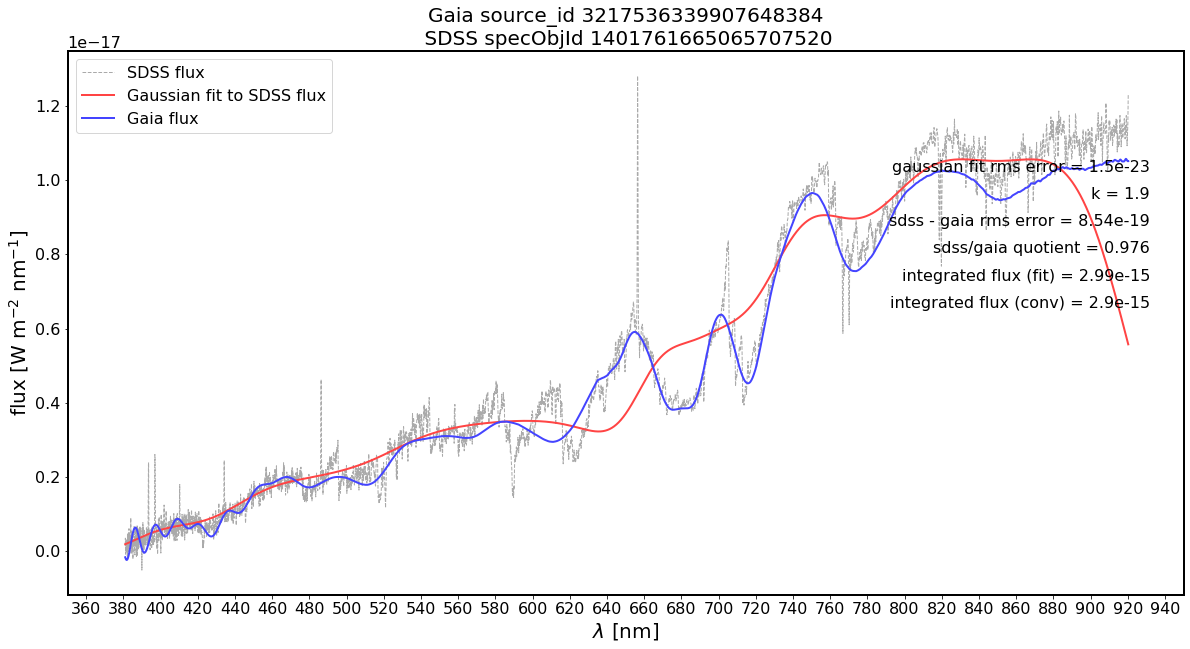

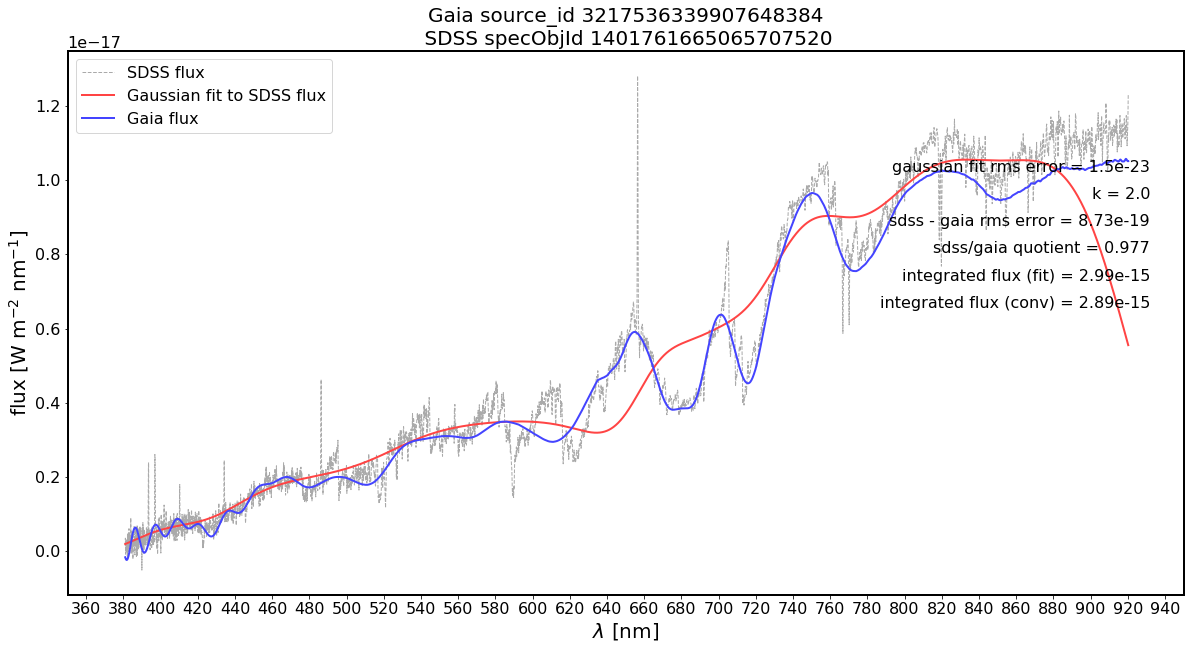

In [249]:
out = {}
for k in np.arange(0.5, 2.01, 0.1):
#     out[k] = plot_conv(gaia_id=3661566306828100224, k=k)
#     out[k] = plot_conv(gaia_id=3694818222807582080, k=k)
#     out[k] = plot_conv(gaia_id=3217574234403744000, k=k)
    out[k] = plot_conv(gaia_id=3217536339907648384, k=k)

In [250]:
for k, avg in out.items():
    print(f'k={k}\tavg={avg}')

k=0.5	avg=4.730599511078393e-19
k=0.6	avg=4.994437217047329e-19
k=0.7	avg=5.299719343032997e-19
k=0.7999999999999999	avg=5.624736446848924e-19
k=0.8999999999999999	avg=5.951779795520927e-19
k=0.9999999999999999	avg=6.270059466344945e-19
k=1.0999999999999999	avg=6.574656106549789e-19
k=1.1999999999999997	avg=6.864257270991338e-19
k=1.2999999999999998	avg=7.139281762422149e-19
k=1.4	avg=7.400744270560854e-19
k=1.4999999999999998	avg=7.649700981443066e-19
k=1.5999999999999996	avg=7.887045489798161e-19
k=1.6999999999999997	avg=8.113484423467662e-19
k=1.7999999999999998	avg=8.329588079170444e-19
k=1.8999999999999997	avg=8.535857821169777e-19
k=1.9999999999999996	avg=8.73278200582736e-19
